# 知识蒸馏BaseLine

In [1]:
import numpy as np
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

## 加载minst数据集

In [2]:
train_data = torchvision.datasets.MNIST(
    root = './data/mnist',  
    train = True,       
    transform = torchvision.transforms.ToTensor(), 
    download = False
)
test_data = torchvision.datasets.MNIST(
    root = './data/mnist',  
    train = False,       
    transform = torchvision.transforms.ToTensor(),
    download = False
)

torch.Size([1, 28, 28]) 5


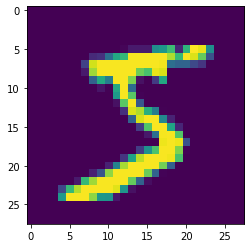

In [3]:
feature, label = train_data[0]
print(feature.shape, label)
plt.imshow(feature.view((28, 28)))

In [4]:
train_iter = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

## Teacher NetWork

In [5]:
from torch.nn import *
from torchsummary import torchsummary
class LeNet(Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = Sequential(Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
                               ReLU(),
                               MaxPool2d(kernel_size=2, stride=2),
                               Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
                               ReLU(),
                               MaxPool2d(kernel_size=2, stride=2))
        self.fc = Sequential(Linear(16*4*4, 120),
                             ReLU(),
                             Linear(120, 84),
                             ReLU(),
                             Linear(84, 10))
    def forward(self, x):
        feature_map = self.conv(x)
        output = self.fc(feature_map.view(x.shape[0], -1))
        return output

In [6]:
t_net = LeNet()
t_net = t_net.cuda()
torchsummary.summary(t_net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [7]:
def evaluate_single_network(test_iter, model, loss):
    model.eval()
    acc_num, test_l_sum, cnt, iter_count = 0, 0, 0, 0
    with torch.no_grad():
        for X, y in test_iter:
            X = X.cuda()
            y = y.cuda()
            cnt += y.shape[0]
            y_hat = model(X)
            l = loss(y_hat, y).cpu().item()
            iter_count += 1
            acc_num += (torch.argmax(y_hat, dim=1) == y).float().sum().item()
            test_l_sum += l
    model.train()
    return acc_num / cnt, test_l_sum/iter_count
            
            
        
def train_single_nerwork(data_iter, test_iter, model, epochs, loss, optim):
    test_accs, test_losses = [], []
    test_acc, test_loss = evaluate_single_network(test_iter, model, loss)
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    print(f'[initial]\tloss:{test_loss:.4f}\tacc:{test_acc:.4f}')
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, iter_count = 0.0, 0.0, 0.0, 0
        for X, y in data_iter:
            X = X.cuda()
            y = y.cuda()
            y_hat = model(X)
            l = loss(y_hat, y)
            optim.zero_grad()
            l.backward()
            optim.step()
            iter_count += 1
            n += y.shape[0]
            train_acc_sum += (torch.argmax(y_hat, dim=1) == y).float().sum().item()
            train_l_sum += l.cpu().item()
        print(f'[train]\tepoch:{epoch + 1}\tloss:{train_l_sum / iter_count:.4f}\tacc:{train_acc_sum / n:.4f}')
        test_acc, test_loss = evaluate_single_network(test_iter, model, loss)
        test_accs.append(test_acc)
        test_losses.append(test_loss)
        print(f'[test]\tepoch:{epoch + 1}\tloss:{test_loss:.4f}\tacc:{test_acc:.4f}')
    return test_accs, test_losses

In [8]:
num_epochs = 5
loss = torch.nn.CrossEntropyLoss()
lr, num_epochs = 0.01, 5
optimizer = torch.optim.Adam(t_net.parameters(), lr=lr)

In [9]:
teacher_history = train_single_nerwork(train_iter, test_iter, t_net, num_epochs, loss, optimizer)

[initial]	loss:2.3036	acc:0.0958
[train]	epoch:1	loss:0.1633	acc:0.9502
[test]	epoch:1	loss:0.0778	acc:0.9750
[train]	epoch:2	loss:0.0850	acc:0.9769
[test]	epoch:2	loss:0.0694	acc:0.9791
[train]	epoch:3	loss:0.0813	acc:0.9781
[test]	epoch:3	loss:0.0779	acc:0.9770
[train]	epoch:4	loss:0.0689	acc:0.9818
[test]	epoch:4	loss:0.0820	acc:0.9814
[train]	epoch:5	loss:0.0697	acc:0.9831
[test]	epoch:5	loss:0.0722	acc:0.9819


## Student Network

In [10]:
class LogisticRegression(Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.layer = Linear(784, 10)
    def forward(self, x):
        output = self.layer(x.view(-1, 784))
        return output

In [11]:
s_net = LogisticRegression()
s_net = s_net.cuda()
torchsummary.summary(s_net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [12]:
num_epochs = 5
loss = torch.nn.CrossEntropyLoss()
lr, num_epochs = 0.01, 5
optimizer = torch.optim.Adam(s_net.parameters(), lr=lr)

In [13]:
student_history = train_single_nerwork(train_iter, test_iter, s_net, num_epochs, loss, optimizer)

[initial]	loss:2.2953	acc:0.1437
[train]	epoch:1	loss:0.3545	acc:0.8994
[test]	epoch:1	loss:0.3261	acc:0.9040
[train]	epoch:2	loss:0.3055	acc:0.9152
[test]	epoch:2	loss:0.3258	acc:0.9116
[train]	epoch:3	loss:0.3030	acc:0.9173
[test]	epoch:3	loss:0.3236	acc:0.9124
[train]	epoch:4	loss:0.2958	acc:0.9202
[test]	epoch:4	loss:0.3390	acc:0.9111
[train]	epoch:5	loss:0.2921	acc:0.9203
[test]	epoch:5	loss:0.3248	acc:0.9164


## Knowledge Distillation

In [14]:
def softmax(logit):
    return torch.exp(logit) / torch.sum(torch.exp(logit))
def softmax_t(logit, T):
    return torch.exp(logit / T) / torch.sum(torch.exp(logit / T))

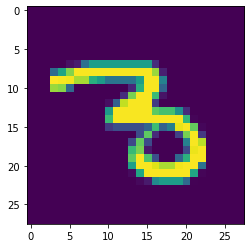

In [15]:
feature = train_data[30][0]
plt.imshow(train_data[30][0].view((28, 28)))

In [16]:
result = t_net(feature.view((1, 1, 28, 28)).cuda())

<BarContainer object of 10 artists>

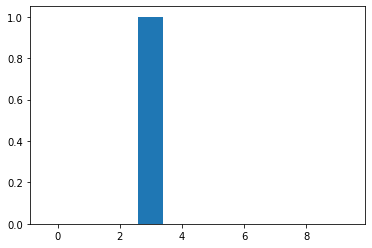

In [17]:
plt.bar(range(0, 10), softmax(result).detach().cpu().numpy()[0])

<BarContainer object of 10 artists>

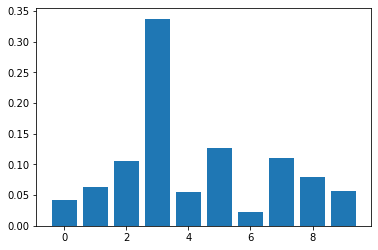

In [18]:
plt.bar(range(0, 10), softmax_t(result, 10).detach().cpu().numpy()[0])

In [19]:
def kd_loss(y_hat, y, y_teacher, T):
    loss_hard = CrossEntropyLoss()(y_hat, y)
    loss_soft = KLDivLoss()(softmax_t(y_teacher, T), softmax(y_hat)) # 这里可以使用交叉熵
    return loss_hard + loss_soft

In [20]:
def evaluate_kd_network(test_iter, student, teacher, loss, T):
    student.eval()
    acc_num, test_l_sum, cnt, iter_count = 0, 0, 0, 0
    with torch.no_grad():
        for X, y in test_iter:
            X = X.cuda()
            y = y.cuda()
            cnt += y.shape[0]
            y_hat = student(X)
            y_teacher = teacher(X).detach()
            l = loss(y_hat, y, y_teacher, T).cpu().item()
            iter_count += 1
            acc_num += (torch.argmax(y_hat, dim=1) == y).float().sum().item()
            test_l_sum += l
    student.train()
    return acc_num / cnt, test_l_sum/iter_count
            
            
        
def train_kd_nerwork(data_iter, test_iter, student, teacher, epochs, loss, optim, T):
    test_accs, test_losses = [], []
    test_acc, test_loss = evaluate_kd_network(test_iter, student, teacher, loss, T)
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    print(f'[initial]\tloss:{test_loss:.4f}\tacc:{test_acc:.4f}')
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, iter_count = 0.0, 0.0, 0.0, 0
        for X, y in data_iter:
            X = X.cuda()
            y = y.cuda()
            y_hat = student(X)
            y_teacher = teacher(X).detach()
            l = loss(y_hat, y, y_teacher, T)
            optim.zero_grad()
            l.backward()
            optim.step()
            iter_count += 1
            n += y.shape[0]
            train_acc_sum += (torch.argmax(y_hat, dim=1) == y).float().sum().item()
            train_l_sum += l.cpu().item()
        print(f'[train]\tepoch:{epoch + 1}\tloss:{train_l_sum / iter_count:.4f}\tacc:{train_acc_sum / n:.4f}')
        test_acc, test_loss = evaluate_kd_network(test_iter, student, teacher, loss, T)
        test_accs.append(test_acc)
        test_losses.append(test_loss)
        print(f'[test]\tepoch:{epoch + 1}\tloss:{test_loss:.4f}\tacc:{test_acc:.4f}')
    return test_accs, test_losses

In [21]:
kd_net = LogisticRegression()
kd_net = kd_net.cuda()
num_epochs = 5
lr, num_epochs = 0.01, 5
optimizer = torch.optim.Adam(kd_net.parameters(), lr=lr)

In [22]:
kd_history = train_kd_nerwork(train_iter, test_iter, kd_net, t_net, num_epochs, kd_loss, optimizer, 10)

C:\ProgramData\Anaconda3\envs\dp_gpu_tf2\lib\site-packages\torch\nn\functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


[initial]	loss:2.2715	acc:0.1084
[train]	epoch:1	loss:0.3540	acc:0.8986
[test]	epoch:1	loss:0.2872	acc:0.9194
[train]	epoch:2	loss:0.3014	acc:0.9155
[test]	epoch:2	loss:0.3055	acc:0.9168
[train]	epoch:3	loss:0.2997	acc:0.9163
[test]	epoch:3	loss:0.2959	acc:0.9196
[train]	epoch:4	loss:0.2926	acc:0.9196
[test]	epoch:4	loss:0.2941	acc:0.9234
[train]	epoch:5	loss:0.2891	acc:0.9193
[test]	epoch:5	loss:0.3157	acc:0.9148


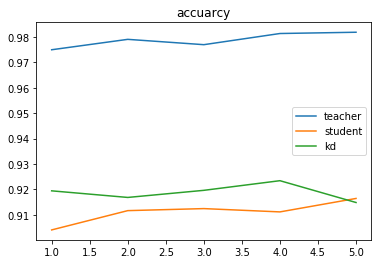

In [28]:
plt.plot(range(1, 6), teacher_history[0][1:], label='teacher')
plt.plot(range(1, 6), student_history[0][1:], label='student')
plt.plot(range(1, 6), kd_history[0][1:], label='kd')
plt.title('accuarcy')
plt.legend()
plt.show()

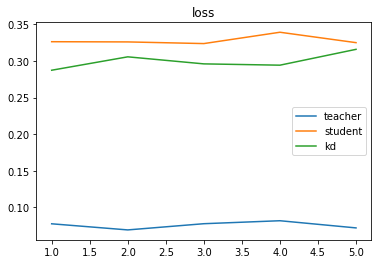

In [29]:
plt.plot(range(1, 6), teacher_history[1][1:], label='teacher')
plt.plot(range(1, 6), student_history[1][1:], label='student')
plt.plot(range(1, 6), kd_history[1][1:], label='kd')
plt.title('loss')
plt.legend()
plt.show()